## Python imports



In [1]:
import matplotlib.pyplot as plt
plt.ioff()
%load_ext autoreload
%autoreload 2

# from pycovid19xray.utils import configure_logging, set_gpu
# configure_logging()
# set_gpu(1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import torch
import torchvision

device = torch.device("cuda")

import os
cwd = os.getcwd()

# plot params
plot_path = Path(cwd) / "figures"
if not plot_path.exists():
    plot_path.mkdir()
figsize = (8, 6)
dpi = 150

jpy_init

### Helpers



In [1]:
import h5py
class Results():
    def __init__(self, save_dir="results"):
        self.save_dir = Path(save_dir)
        if not self.save_dir.exists():
            self.save_dir.mkdir()

        self.pred_classes = np.empty(len(dataset), dtype="S10")
        self.pred_labels = np.zeros(len(dataset))

        self.true_classes = np.empty(len(dataset), dtype="S10")
        self.true_labels = np.zeros(len(dataset))

        self.pred_scores = np.zeros(len(dataset))
        self.all_scores = np.zeros((len(dataset), 3))
    def save(self, name):
        with h5py.File(self.save_dir / f'{name}.h5', 'w') as hf:
            hf.create_dataset('pred_classes', data=self.pred_classes)
            hf.create_dataset('pred_labels', data=self.pred_labels)
            hf.create_dataset('true_classes', data=self.true_classes)
            hf.create_dataset('true_labels', data=self.true_labels)
            hf.create_dataset('pred_scores', data=self.pred_scores)
            hf.create_dataset('all_scores', data=self.all_scores)
    def load(self, name):
        with h5py.File(self.save_dir / f'{name}.h5', 'r') as hf:
            self.pred_classes = np.array(hf.get('pred_classes'))
            self.pred_labels = np.array(hf.get('pred_labels'))
            self.true_classes = np.array(hf.get('true_classes'))
            self.true_labels = np.array(hf.get('true_labels'))
            self.pred_score =  np.array(hf.get('pred_scores'))
            self.all_scores = np.array(hf.get('all_scores'))

def save_fig(fig, name, modelname):
    fig.savefig(str(plot_path/ modelname / (name + ".jpg")),dpi=dpi,
                bbox_inches="tight")
    plt.close()

jpy_helpers

## Model interpretation on resnet50 imagenet



### helpers



In [1]:
def plot_att(att0, att1, name, p_func):
    fig, axs = plt.subplots(1,3,
                            figsize=figsize,
                            dpi=dpi,
                            sharex=False, sharey=False)
    axs[0].imshow(toplot_img)
    axs[0].title.set_text("Image")
    axs[0].axis('off')
    p_func(toplot_img, att0, fig, axs[1])
    axs[1].title.set_text("Dog")
    p_func(toplot_img, att1, fig, axs[2])
    axs[2].title.set_text("Cat")
    plt.tight_layout()
    plt.show()
    save_fig(fig, name, modelname)

### load model



In [1]:
from pycovid19xray.tests.test_explainer import (given_resnet50)
from pycovid19xray.explainer import Explainer

modelname = "rs50-imagenet"
if not (plot_path / modelname).exists():
    (plot_path / modelname).mkdir()
model, layer, transform, transform_normalize, class_idx, img_path =\
    given_resnet50()
explainer = Explainer(model,
                      layer,
                      "rs50-imagenet",
                      transform,
                      transform_normalize,
                      class_idx,
                      cache_path="./cache")

#+attr_org: :width 257

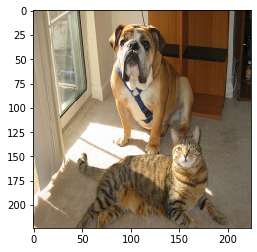

In [1]:
img, transformed_img, inp = explainer.open_image(img_path)
toplot_img = np.transpose(transformed_img
                          .cpu()
                          .detach().numpy(), (1,2,0))
plt.imshow(toplot_img)
plt.show()

### Prediction



In [1]:
output = explainer.model(inp)
output = torch.nn.functional.softmax(output, dim=1)
prediction_score, pred_label_idx = torch.topk(output, 2)
for i in pred_label_idx[0].cpu().numpy():
    print(class_idx[i])

bull_mastiff
tiger_cat

### Occlusion



In [1]:
target = pred_label_idx[0,0]
att0 = explainer.compute_occlusion(img_path, target)
target = pred_label_idx[0,1]
att1 = explainer.compute_occlusion(img_path, target)

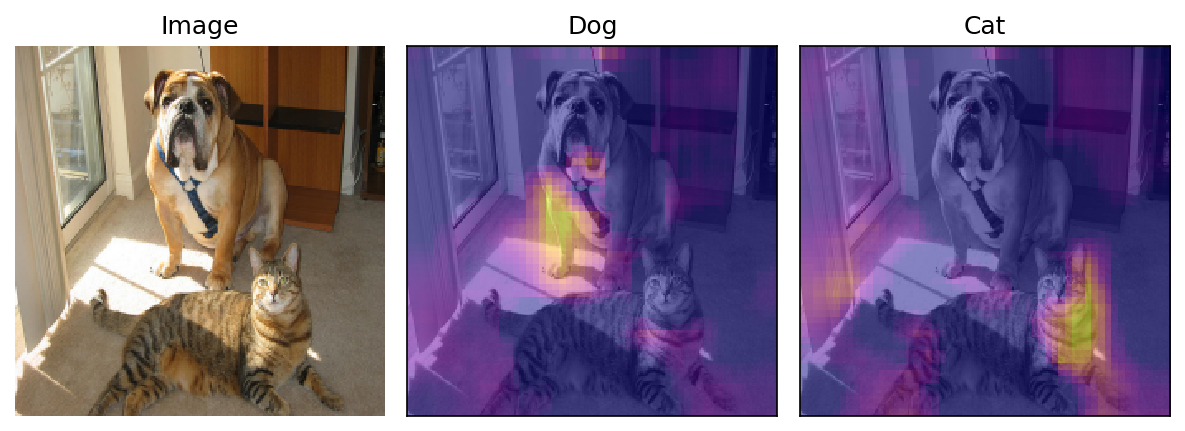

In [1]:
plot_att(att0, att1, "rs50_occ", explainer.draw_occlusion)

### Integrated gradient



In [1]:
target = pred_label_idx[0,0]
att0 = explainer.compute_integrated_gradients(img_path, target)
target = pred_label_idx[0,1]
att1 = explainer.compute_integrated_gradients(img_path, target)

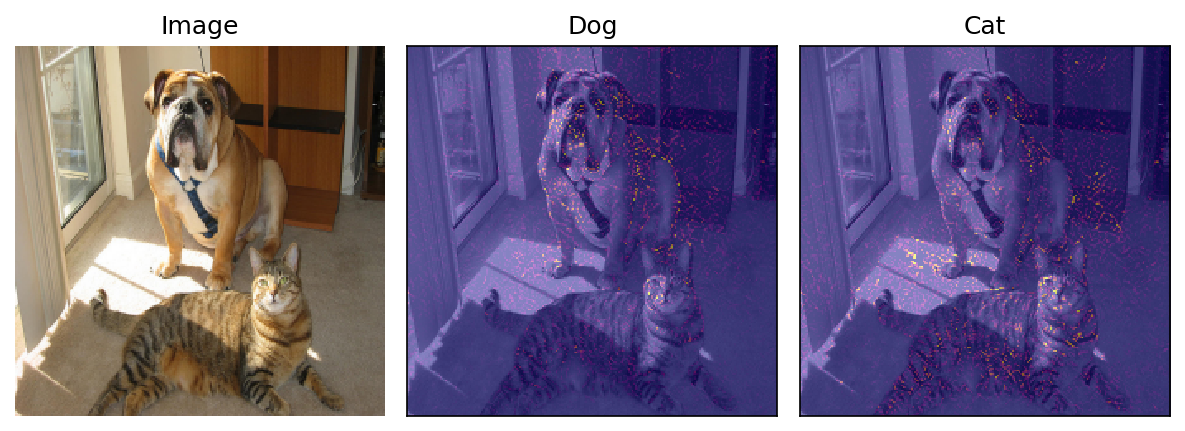

In [1]:
plot_att(att0, att1, "rs50_ig", explainer.draw_integrated_gradients)

### Integrated gradient with noise tunnel



In [1]:
target = pred_label_idx[0,0]
att0 = explainer.compute_integrated_gradients_noise_tunnel(img_path, target)
target = pred_label_idx[0,1]
att1 = explainer.compute_integrated_gradients_noise_tunnel(img_path, target)

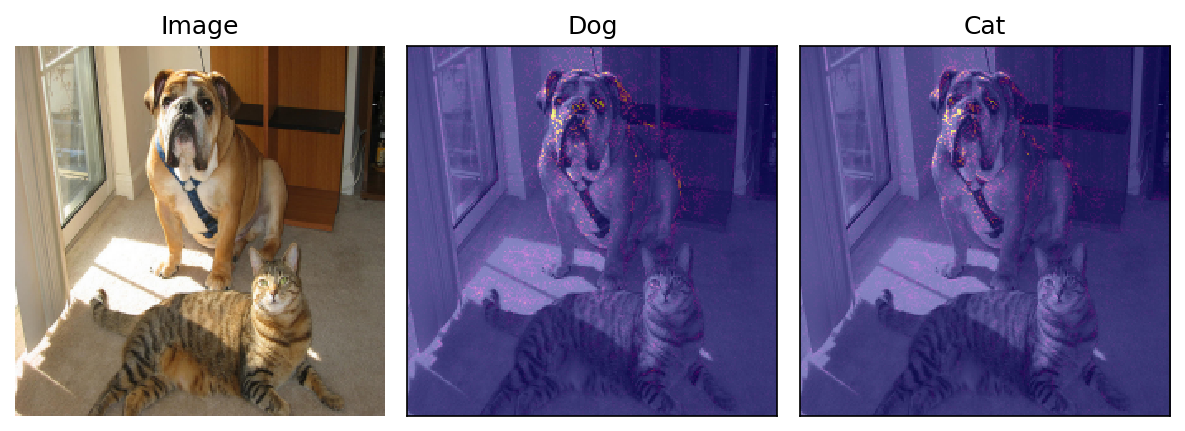

In [1]:
plot_att(att0, att1, "rs50_ig_nt", explainer.draw_integrated_gradients_noise_tunnel)

### Saliency



In [1]:
target = pred_label_idx[0,0]
att0 = explainer.compute_saliency(img_path, target)
target = pred_label_idx[0,1]
att1 = explainer.compute_saliency(img_path, target)

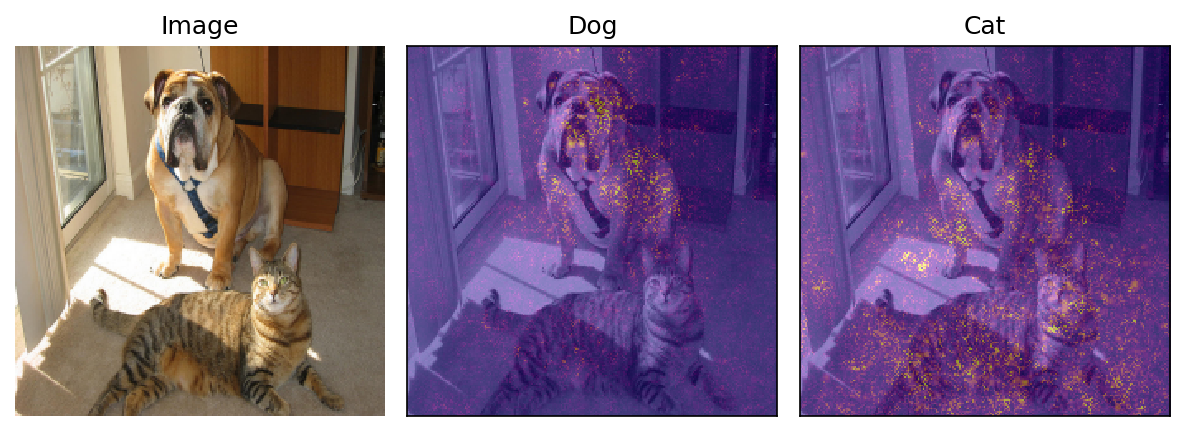

In [1]:
plot_att(att0, att1, "rs50_sa", explainer.draw_saliency)

### Saliency with noise tunnel



In [1]:
target = pred_label_idx[0,0]
att0 = explainer.compute_saliency_noise_tunnel(img_path, target)
target = pred_label_idx[0,1]
att1 = explainer.compute_saliency(img_path, target)

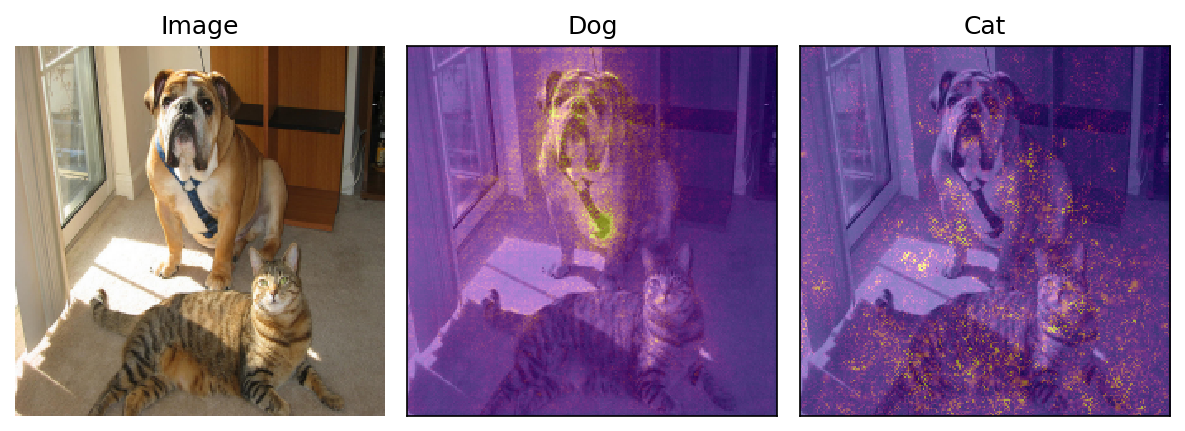

In [1]:
plot_att(att0, att1, "rs50_sa", explainer.draw_saliency)

### gradient SHAP



In [1]:
target = pred_label_idx[0,0]
att0 = explainer.compute_gradient_shap(img_path, target)
target = pred_label_idx[0,1]
att1 = explainer.compute_gradient_shap(img_path, target)

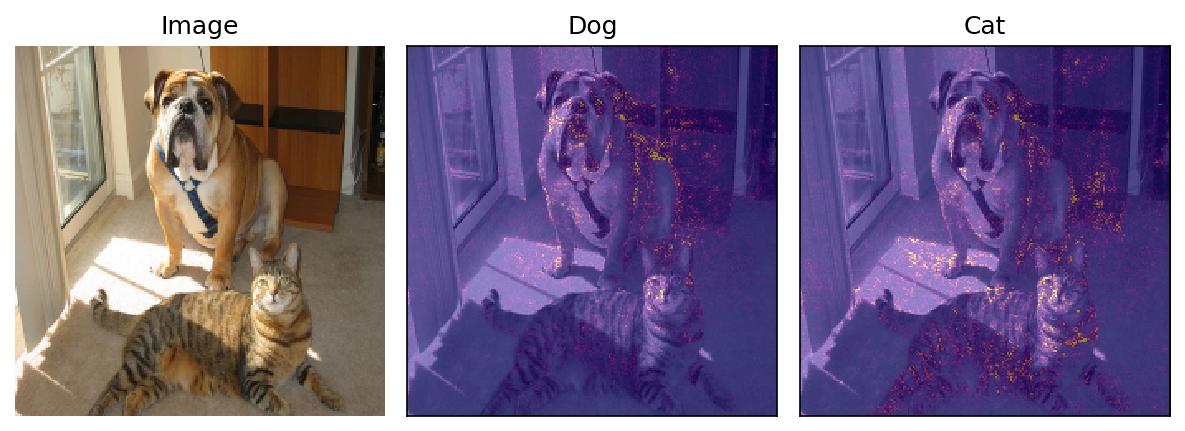

In [1]:
plot_att(att0, att1, "rs50_gs", explainer.draw_gradient_shap)

### Gradcam



In [1]:
target = pred_label_idx[0,0]
att0 = explainer.compute_gradcam(img_path, target)
target = pred_label_idx[0,1]
att1 = explainer.compute_gradcam(img_path, target)

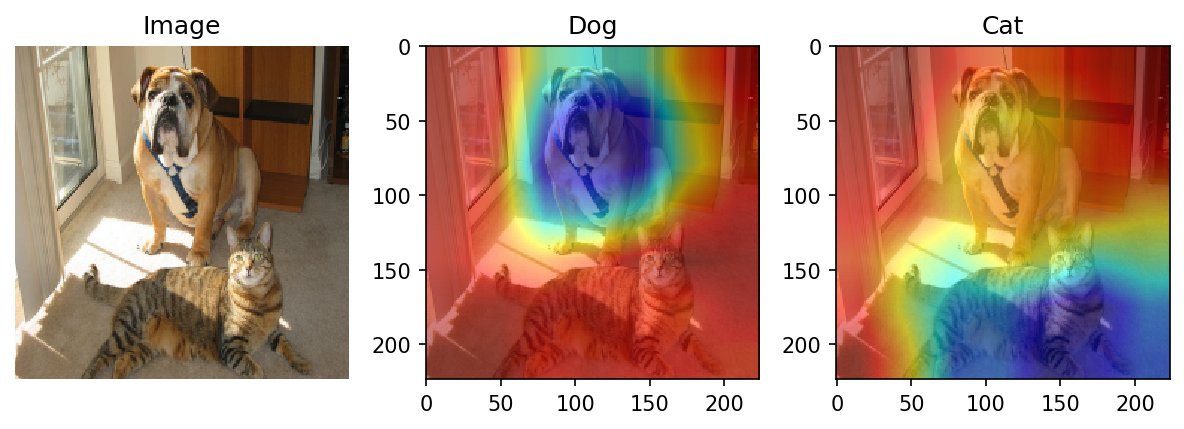

In [1]:
plot_att(att0, att1, "rs50_gc", explainer.draw_gradcam)

### guided gradcam



In [1]:
target = pred_label_idx[0,0]
att0 = explainer.compute_guided_gradcam(img_path, target)
target = pred_label_idx[0,1]
att1 = explainer.compute_guided_gradcam(img_path, target)

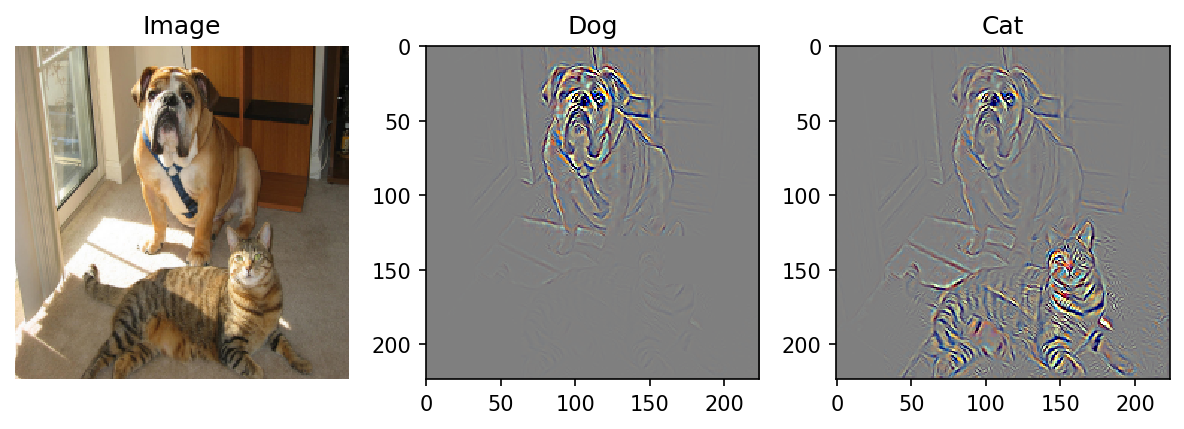

In [1]:
plot_att(att0, att1, "rs50_guided_gc", explainer.draw_guided_gradcam)

## Model interpretation on resnet50 COVIDxV3



Model trained using fastai see ../scripts/train<sub>resnet</sub><sub>covidx.py</sub>



### load model



In [1]:
from tqdm import tqdm
from torchvision import transforms
from pycovid19xray.explainer import Explainer
from pycovid19xray.tests import DATA_DIR
from pycovid19xray.tests.utils import (load_fastai_model, load_test_dataset,
                                       denormalize_f, load_test_df)
modelname = "fastai-rs50-dataaug-covidxv3"
fastaimodelname = 'rs50-dataaug'
if not (plot_path / modelname).exists():
    (plot_path / modelname).mkdir()
model, target_names = load_fastai_model(fastaimodelname)
model = model.to(device).eval()
resnet_core = next(model.children())
last_cnn_layer = list(resnet_core.children())[7]
data_df = load_test_df()
data_path = DATA_DIR / "COVIDx/test"

model_class_idx = {0: "COVID-19", 1: "normal", 2: "pneumonia"}

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
transform_normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)

explainer = Explainer(model,
                      last_cnn_layer,
                      f"{modelname}-covidx",
                      transform,
                      transform_normalize,
                      model_class_idx,
                      cache_path="./cache")

2020-07-23 15:36:38,491 INFO	Reading train_df from train_split_v3.txt
2020-07-23 15:36:38,534 INFO	Reading test_df from test_split_v3.txt
2020-07-23 15:36:41,168 INFO	prop in train set: [0.026825 0.577467 0.395708]
2020-07-23 15:36:41,171 INFO	prop in valid set: [0.063331 0.560481 0.376187]
2020-07-23 15:36:41,172 INFO	prop in test set: [0.333333 0.333333 0.333333]

In [1]:
explainer.arraycache.clear_cache()

### Plot some data



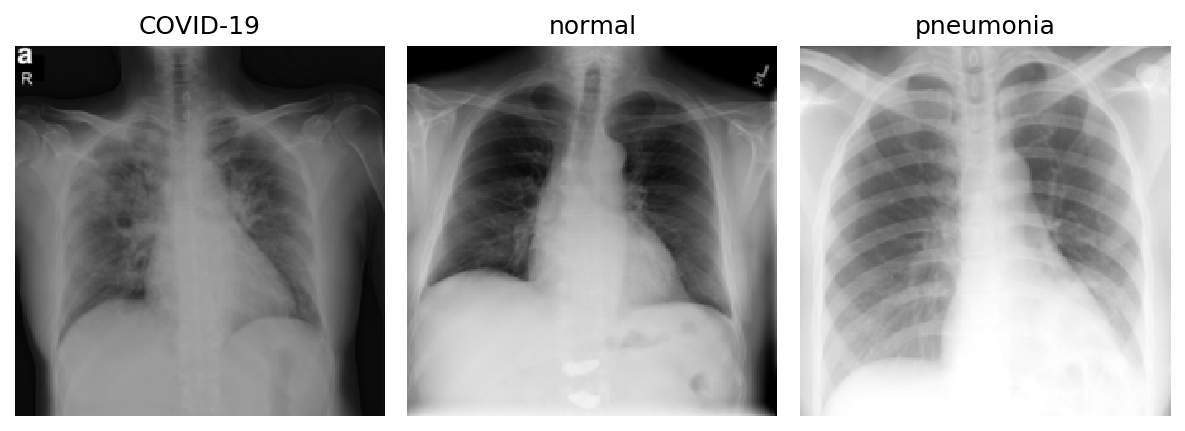

In [1]:
plt.close("all")
fig, axs = plt.subplots(1,3,
                        figsize=figsize,
                        dpi=dpi,
                        sharex=False, sharey=False)
for ((label, g_df), ax) in zip(data_df.groupby("label"), axs):
    img_path = data_path / g_df.img.values[0]
    img, transformed_img, inp = explainer.open_image(img_path)
    toplot_img = np.transpose(transformed_img
                              .cpu()
                              .detach().numpy(), (1,2,0))
    ax.imshow(toplot_img)
    ax.title.set_text(f"{label}")
    ax.axis('off')
plt.tight_layout()
plt.show()
plt.close()

### Metrics



In [1]:
from pycovid19xray.fastai import FastaiModel, show_metrics
fastaimodel = FastaiModel(modelname=fastaimodelname,
                          bs=64) 
data, test = fastaimodel.create_covidx_databunch()
test_data = test.databunch()

learn = fastaimodel.create_learner(data)
learn = fastaimodel.load_learner(learn, "stage-2")
show_metrics(learn, test)

#+begin_example
2020-07-23 15:38:02,260 INFO	Reading train_df from train_split_v3.txt
2020-07-23 15:38:02,297 INFO	Reading test_df from test_split_v3.txt
2020-07-23 15:38:04,929 INFO	prop in train set: [0.026825 0.577467 0.395708]
2020-07-23 15:38:04,932 INFO	prop in valid set: [0.063331 0.560481 0.376187]
2020-07-23 15:38:04,934 INFO	prop in test set: [0.333333 0.333333 0.333333]
<IPython.core.display.HTML object>= VALIDATION SET: covidx whole test set=

[[ 69.   8.  23.]
 [  1. 823.  61.]
 [  0.  25. 569.]]
Sens COVID-19: 0.690, Normal: 0.930, Pneumonia: 0.958
PPV COVID-19: 0.986, Normal: 0.961, Pneumonia: 0.871
              precision    recall  f1-score   support

    COVID-19       0.99      0.69      0.81       100
      Normal       0.96      0.93      0.95       885
   Pneumonia       0.87      0.96      0.91       594

    accuracy                           0.93      1579
   macro avg       0.94      0.86      0.89      1579
weighted avg       0.93      0.93      0.92      157

Confusion matrix



In [1]:
import fastai.vision as fv
interp = fv.ClassificationInterpretation.from_learner(learn)

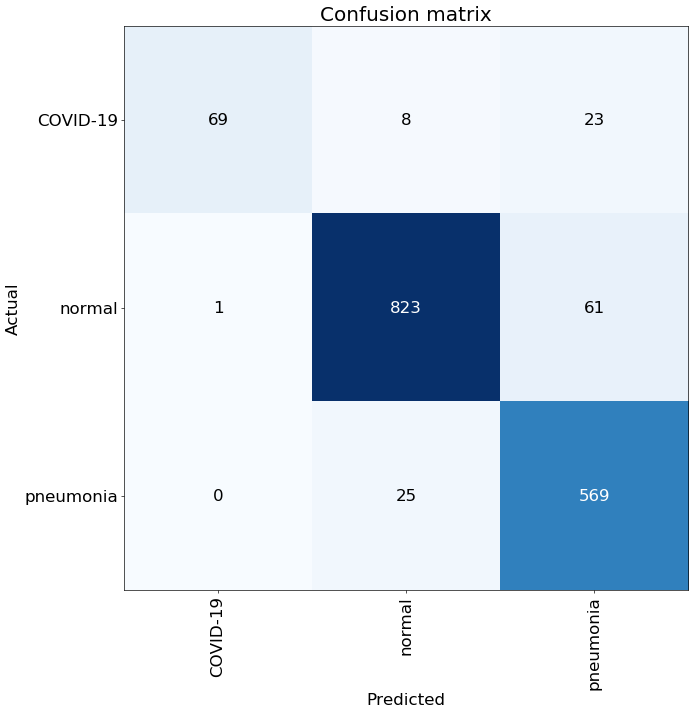

In [1]:
plt.rcParams.update({'font.size': 20})
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)
plt.show()

### helpers



In [1]:
def explain_one(index, row, method, compute_f, draw_f):
    # read image
    img_path = data_path / row.img
    true_label = row.label
    img, transformed_img, inp = explainer.open_image(img_path)
    toplot_img = np.transpose(transformed_img
                              .cpu()
                              .detach().numpy(), (1,2,0))

    # compute prediction
    output = explainer.model(inp)
    output = torch.nn.functional.softmax(output, dim=1)
    prediction_score, pred_label_idx = torch.topk(output, 1)
    pred_label = explainer.class_idx[pred_label_idx.cpu().numpy()[0,0]]
    output = output.squeeze().detach().cpu().numpy()
    title = [f"{label}: {output[i]:.2f}"
               for (i, label) in explainer.class_idx.items()]
    # title = ", ".join(title)

    # plot image
    fig, axs = plt.subplots(2,2,
                            figsize=figsize,
                            dpi=dpi,
                            sharex=False, sharey=False)
    axs[0,0].imshow(toplot_img)
    axs[0,0].title.set_text(f"{true_label}")
    axs[0,0].axis('off')

    # plot gradcam for each label
    for ((i, label), ax) in zip(model_class_idx.items(), axs.ravel()[1:]):
        att = compute_f(img_path, torch.tensor(i))
        draw_f(toplot_img, att, fig, ax)
        ax.title.set_text(title[i])
        ax.axis('off')
    plt.tight_layout()
    save_fig(fig, f"{method}_{true_label}_{index}_{pred_label}_{row.img}", modelname)

ipyt_explainone

### Explain covid



In [1]:
covid_df = (data_df.query("label == 'COVID-19'")
            .reset_index(drop=True))
covid_df.describe()

img     label dataset
count                100       100     100
unique               100         1       4
top     COVID-19(94).png  COVID-19   cohen
freq                   1       100      39

#### Gradcam



In [1]:
methodname = "GradCam"
compute_f, draw_f = explainer.methods[methodname]
plt.close("all")
for index, row in tqdm(covid_df.iterrows()):
    explain_one(index, row, methodname,
                compute_f,
                draw_f)
plt.close("all")
# plt.show()

100it [01:01,  1.63it/s]

#### Occlusion



In [1]:
methodname = "occlusion"
compute_f, draw_f = explainer.methods[methodname]
plt.close("all")
for index, row in tqdm(covid_df.iterrows()):
    explain_one(index, row, methodname,
                compute_f,
                draw_f)
plt.close("all")
# plt.show()

KeyboardInterrupt: 
#+end_example

### Explain normal



In [1]:
normal_df = (data_df.query("label == 'normal'")
            .reset_index(drop=True))

normal_df.describe()

img   label dataset
count                                        885     885     885
unique                                       885       1       1
top     64055d79-d3c0-4914-9344-3b38f01650d5.png  normal    rsna
freq                                           1     885     885

#### Gradcam



In [1]:
methodname = "GradCam"
compute_f, draw_f = explainer.methods[methodname]
plt.close("all")
for index, row in tqdm(normal_df.iterrows()):
    explain_one(index, row, methodname,
                compute_f,
                draw_f)
plt.close("all")
# plt.show()

885it [05:24,  2.73it/s]

#### Occlusion



In [1]:
methodname = "occlusion"
compute_f, draw_f = explainer.methods[methodname]
plt.close("all")
for index, row in tqdm(normal_df.iterrows()):
    explain_one(index, row, methodname,
                compute_f,
                draw_f)
plt.close("all")
# plt.show()

885it [1:15:06,  5.09s/it]

### Explain pneumonia



In [1]:
pneumonia_df = (data_df.query("label == 'pneumonia'")
            .reset_index(drop=True))

pneumonia_df.describe()

img      label dataset
count                                        594        594     594
unique                                       594          1       2
top     b6158255-d002-48a7-a283-af4ad2d8874a.png  pneumonia    rsna
freq                                           1        594     589

#### Gradcam



In [1]:
methodname = "GradCam"
compute_f, draw_f = explainer.methods[methodname]
plt.close("all")
for index, row in tqdm(pneumonia_df.iterrows()):
    explain_one(index, row, methodname,
                compute_f,
                draw_f)
plt.close("all")
# plt.show()

594it [06:18,  1.57it/s]

#### Occlusion



In [1]:
methodname = "occlusion"
compute_f, draw_f = explainer.methods[methodname]
plt.close("all")
for index, row in tqdm(normal_df.iterrows()):
    explain_one(index, row, methodname,
                compute_f,
                draw_f)
plt.close("all")
# plt.show()

885it [1:15:06,  5.09s/it]

### Take a Look at results



#### helpers



In [1]:
def plot_gradcam_occlusion(img_path, true_label, explainer, figname=None, toplot_label=None):

    # read image
    img, transformed_img, inp = explainer.open_image(img_path)
    toplot_img = np.transpose(transformed_img
                              .cpu()
                              .detach().numpy(), (1,2,0))

    # compute prediction
    output = explainer.model(inp)
    output = torch.nn.functional.softmax(output, dim=1)
    prediction_score, pred_label_idx = torch.topk(output, 1)
    pred_label = explainer.class_idx[pred_label_idx.cpu().numpy()[0,0]]
    output = output.squeeze().detach().cpu().numpy()
    if not toplot_label is None:
        pred_label_idx = torch.tensor(toplot_label)
        pred_label = explainer.class_idx[toplot_label]
    caption = [f"{label}: {output[i]:.2f}"
             for (i, label) in explainer.class_idx.items()]
    caption = ", ".join(caption)
    caption = f"Scores: {caption}"

    # plot image
    fig, axs = plt.subplots(1,3,
                            figsize=(8,3.5),
                            dpi=dpi,
                            sharex=False, sharey=False)
    fig.suptitle(f"True class: {true_label}")
    fig.text(.5, .05, caption, ha='center')
    axs[0].imshow(toplot_img)
    axs[0].title.set_text(f"Image")
    axs[0].axis('off')

    # plot gradcam for each label
    method_dict = {k: n for (k, n) in explainer.methods.items()
                   if k in ['GradCam', 'occlusion']}
    for ((methodname, (compute_f, draw_f)), ax) in zip(method_dict.items(), axs.ravel()[1:]):
        att = compute_f(img_path, pred_label_idx)
        draw_f(toplot_img, att, fig, ax)
        # ax.title.set_text(f"{methodname} attributions in {pred_label} output.")
        ax.axis('off')
    plt.tight_layout()
    # save_fig(fig, figname, modelname)

#### On normal data



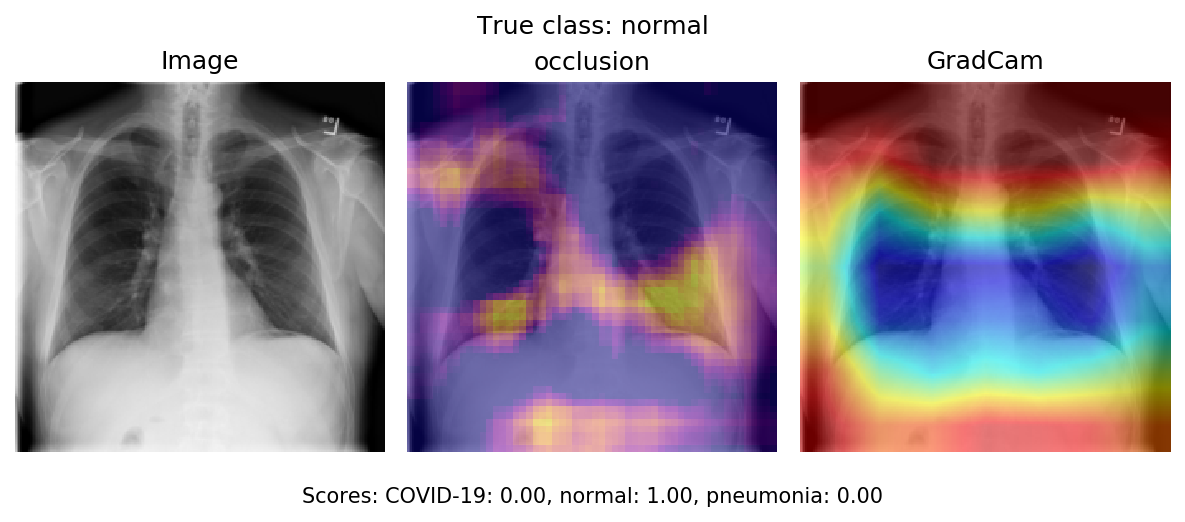

In [1]:
true_label = "normal"
img_path = data_path / "3e8b04ac-40e4-499b-8677-8c0cf1c43c05.png"
plot_gradcam_occlusion(img_path, true_label, explainer)
plt.show()

The critical part for the model to predict a normal output on this image are
located un the lung. Moreover the whole lung is important.



#### On Pneumonia



**Prediction ok**



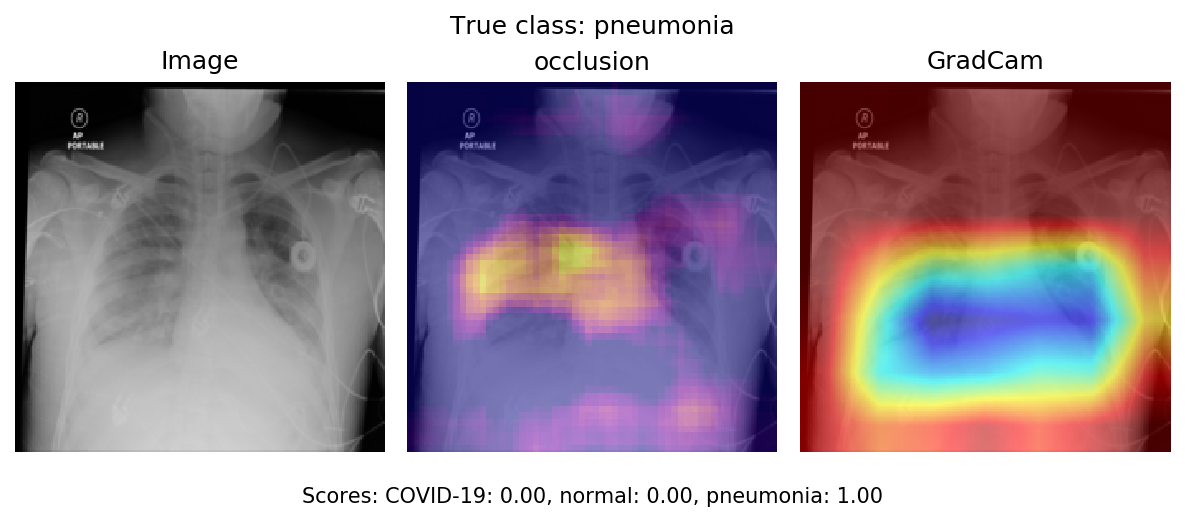

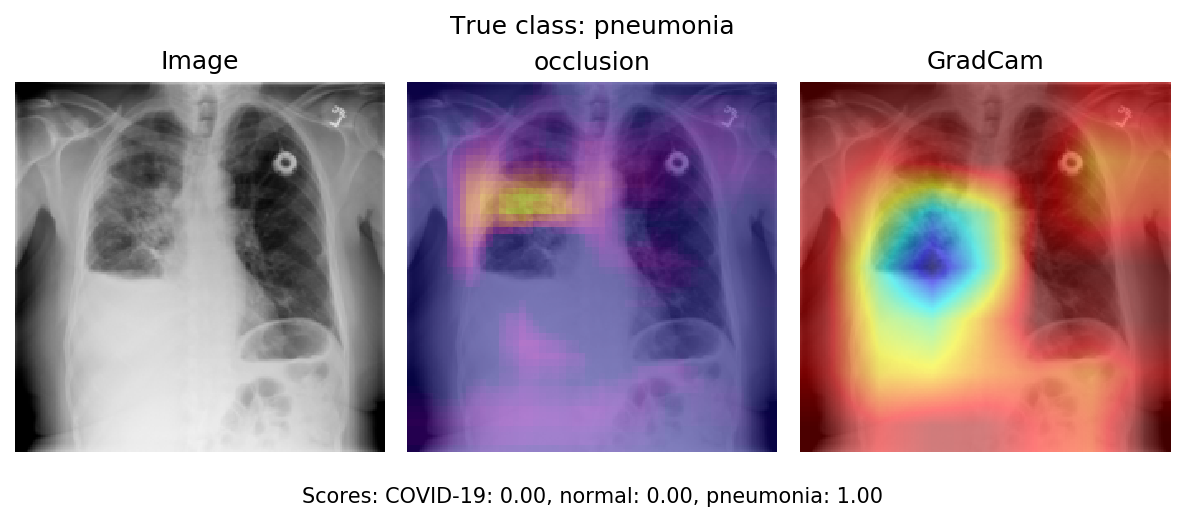

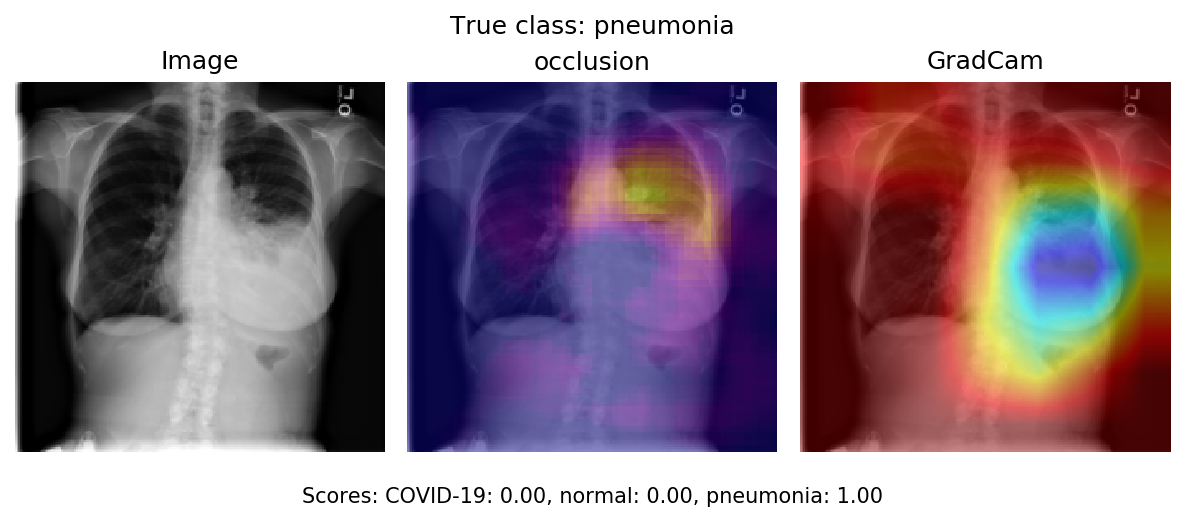

In [1]:
true_label = "pneumonia"
img_names = ["34ba0b9f-640e-4e8d-9f60-3e6094cd3e50.png",
             "34fbff70-fa6e-4709-ab07-17f739fce394.png",
             "43605721-d0e0-4d58-b212-b05a295b21be.png"]
for n in img_names:
    img_path = data_path / n
    plot_gradcam_occlusion(img_path, true_label, explainer)
    plt.show()

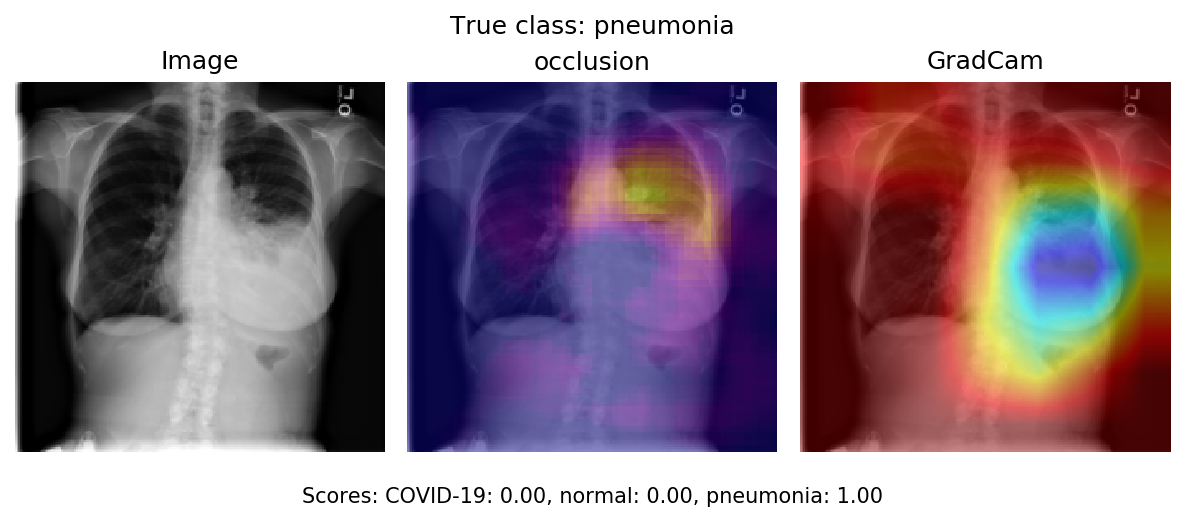

In [1]:
true_label = "pneumonia"
img_names = [
             "43605721-d0e0-4d58-b212-b05a295b21be.png"]
for n in img_names:
    img_path = data_path / n
    plot_gradcam_occlusion(img_path, true_label, explainer)
    plt.show()

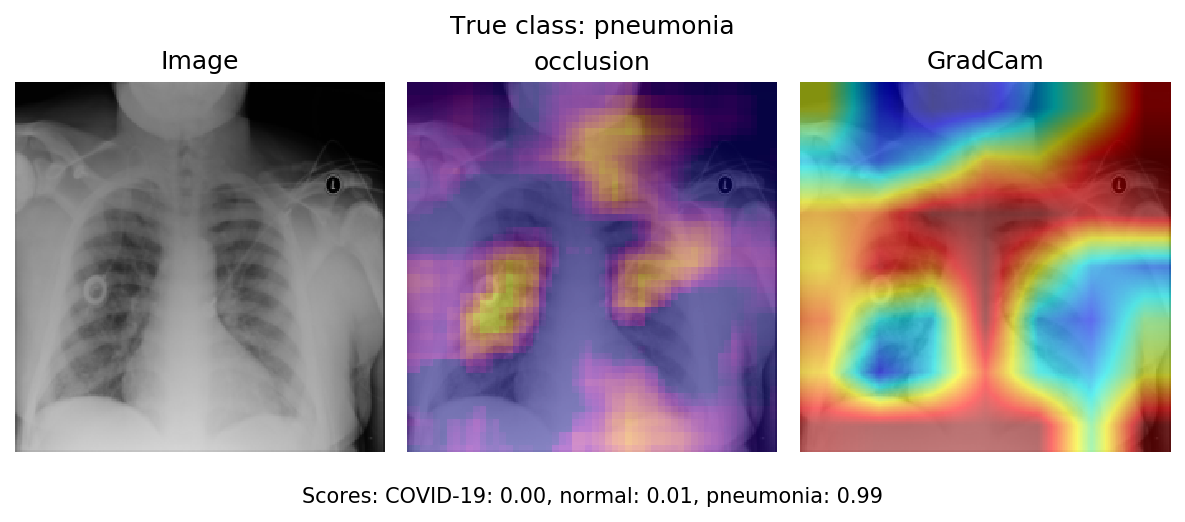

In [1]:
true_label = "pneumonia"
img_names = [
             "3f30b3ca-a94b-4305-bd38-1895aaa07427.png"]
for n in img_names:
    img_path = data_path / n
    plot_gradcam_occlusion(img_path, true_label, explainer)
    plt.show()

**Prediction ok but interpretation is not good**



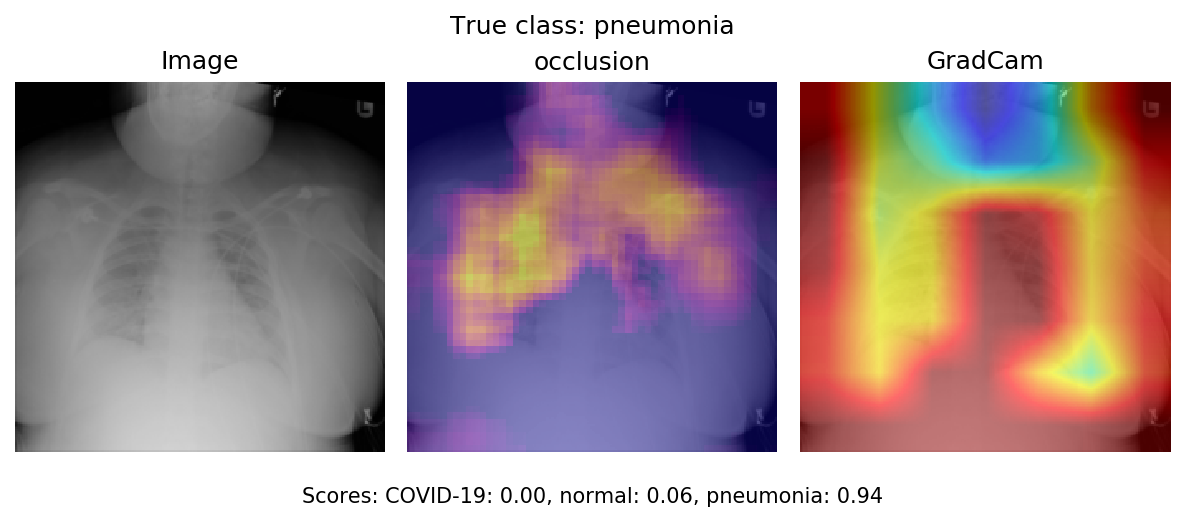

In [1]:
true_label = "pneumonia"
img_names = ["bfd6493b-7b0d-4bb6-a7ed-bd69007dc433.png"]
for n in img_names:
    img_path = data_path / n
    plot_gradcam_occlusion(img_path, true_label, explainer)
    plt.show()

#### On Covid19



**Prediction OK**



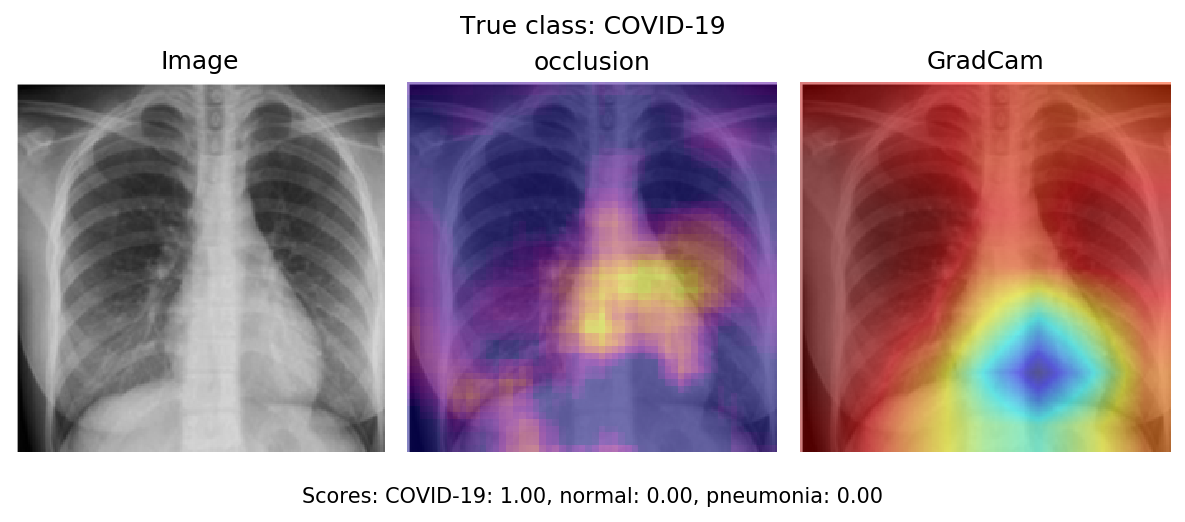

In [1]:
true_label = "COVID-19"
img_names = ["COVID-19(72).png"]
for n in img_names:
    img_path = data_path / n
    plot_gradcam_occlusion(img_path, true_label, explainer)
    plt.show()

**Prediction NOT OK**



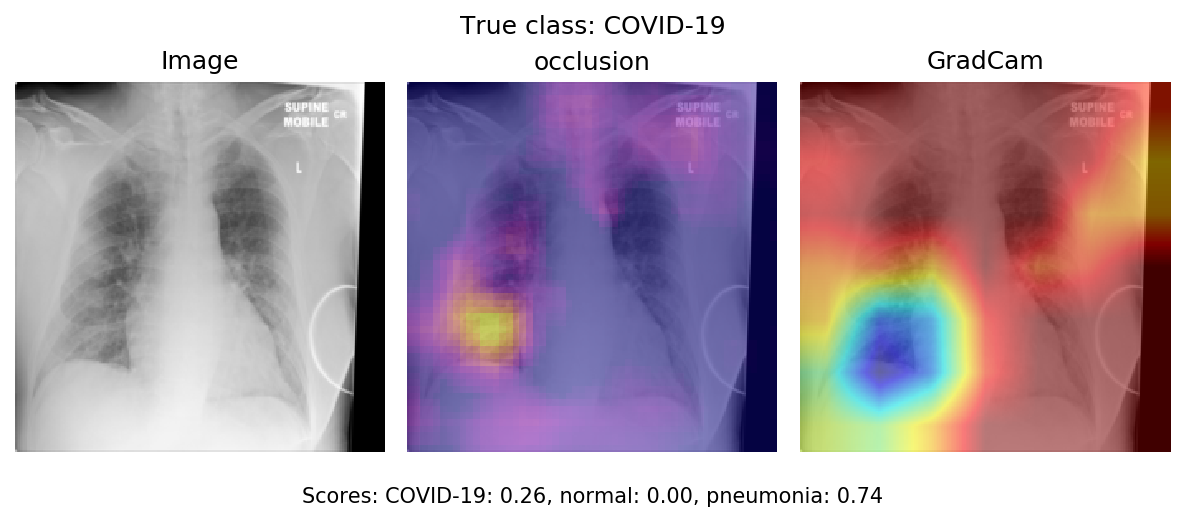

In [1]:
true_label = "COVID-19"
img_names = ["covid-19-pneumonia-23-day1.jpg"]
for n in img_names:
    img_path = data_path / n
    plot_gradcam_occlusion(img_path, true_label, explainer)
    plt.show()

We can plot attribution for COVID-19



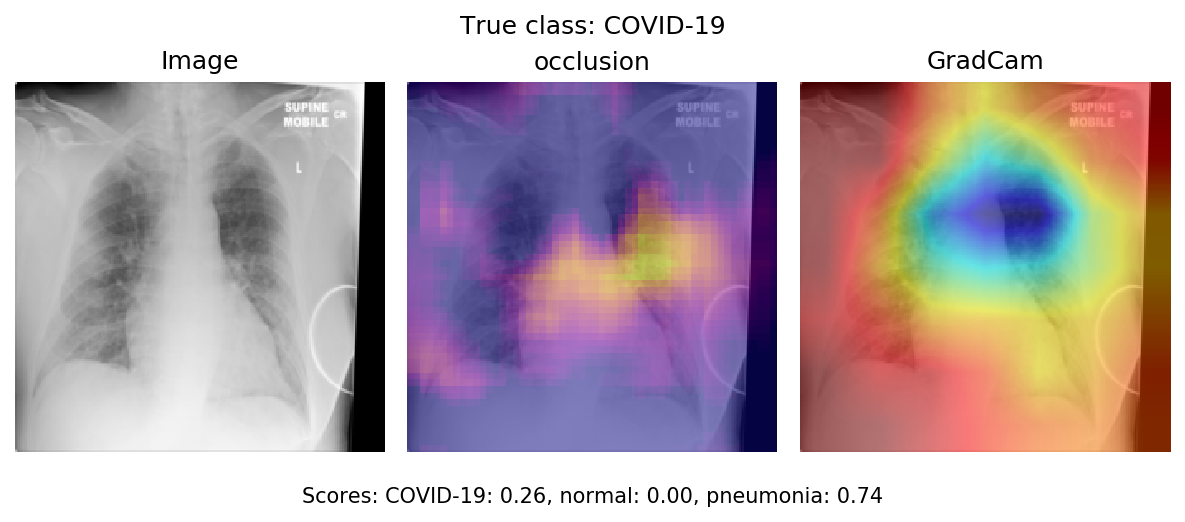

In [1]:
true_label = "COVID-19"
img_names = ["covid-19-pneumonia-23-day1.jpg"]
for n in img_names:
    img_path = data_path / n
    plot_gradcam_occlusion(img_path, true_label, explainer, toplot_label=0)
    plt.show()

**Prediction OK but interpretation not ok**



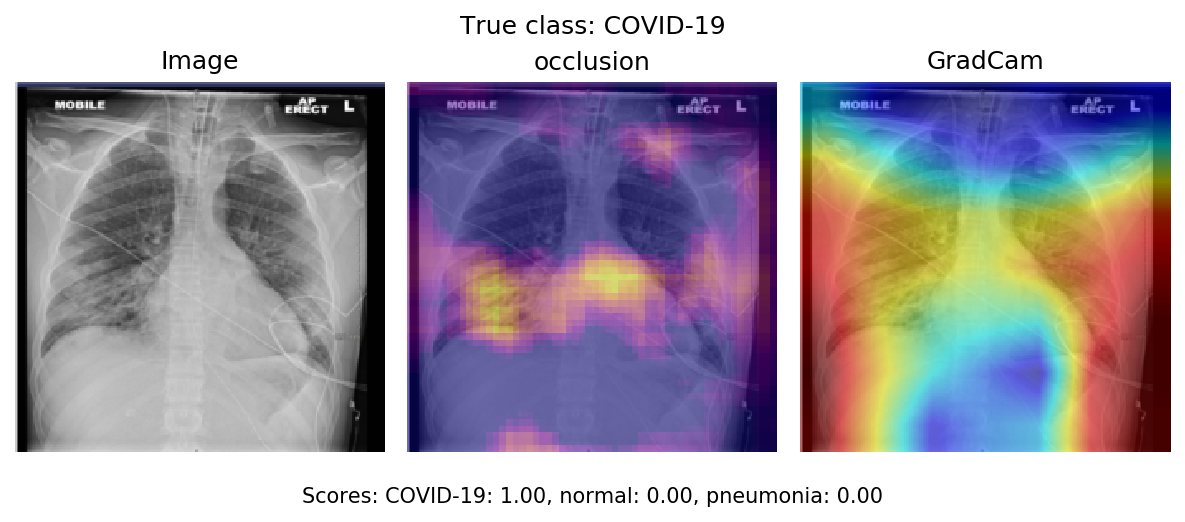

In [1]:
true_label = "COVID-19"
img_names = ["figure1-5e7c1b8d98c29ab001275405-98-later.jpeg"]
for n in img_names:
    img_path = data_path / n
    plot_gradcam_occlusion(img_path, true_label, explainer, toplot_label=0)
    plt.show()